# Effects of Averaging Then Flattening the Data

This notebook investigates the effect of averaging packets of data and then flattening the data out. A 100 elements are collected at 100Hz so we recieve a packet of data every second or so.

In [1]:
import pandas as pd
import numpy as np
import unittest
import altair as alt

from src.data_processing import create_data_from_entry, flatten_data, time_period, unstable_seconds, row_moving_average_filter
from src.data_processing import clean_camonitored_data, calibrate_data
from src.vizualization import generate_stability_rules, generate_line_chart

# Render altair charts correctly
alt.renderers.enable('notebook')

# Store the altair char json separately and not in the notebook to reduce
# notebook size
alt.data_transformers.enable('json')

%load_ext autoreload
%autoreload 2

## Load and Clean The Data

First, we want to import the raw dataset with sparks obtained by camonitoring the PV which collects the raw voltage data.

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), "..", "data", "raw", "2018-11-09-voltage-data-sparks.txt"), 
                   delim_whitespace=True, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,IN:MUONFE:SEPRTR_01:DAQ:VOLT:_RAW,2018-11-09,11:47:09.498566,100,4.80261,4.51632,4.80037,4.51632,4.80292,4.51345,...,4.79336,4.52652,4.79177,4.52652,4.79145,4.52588,4.79145,4.52588,4.79145,4.52684
1,IN:MUONFE:SEPRTR_01:DAQ:VOLT:_RAW,2018-11-09,11:47:10.660728,100,4.81408,4.50166,4.81440,4.50229,4.81440,4.50166,...,4.82142,4.49560,4.82142,4.49719,4.82142,4.49783,4.81950,4.49815,4.82014,4.49719
2,IN:MUONFE:SEPRTR_01:DAQ:VOLT:_RAW,2018-11-09,11:47:11.842031,100,4.77359,4.54374,4.77073,4.54565,4.77200,4.54246,...,4.76180,4.54852,4.76244,4.55458,4.76180,4.55490,4.76052,4.55330,4.76339,4.55235
3,IN:MUONFE:SEPRTR_01:DAQ:VOLT:_RAW,2018-11-09,11:47:13.021381,100,4.75032,4.56542,4.74937,4.56478,4.75032,4.56382,...,4.73853,4.57976,4.74044,4.57913,4.74235,4.57594,4.73916,4.57753,4.73853,4.57753
4,IN:MUONFE:SEPRTR_01:DAQ:VOLT:_RAW,2018-11-09,11:47:14.202799,100,4.80834,4.50771,4.81058,4.50708,4.81026,4.50612,...,4.80803,4.51026,4.80898,4.50931,4.80803,4.50899,4.80675,4.51090,4.80834,4.50899


Now we clean the dataset and calibrate the voltage.

In [3]:
data = clean_camonitored_data(data)
calibrated_data = calibrate_data(data, 20)
calibrated_data.head()

,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,Datetime
0,96.0522,90.3264,96.0074,90.3264,96.0584,90.2690,96.0394,90.2690,96.0394,90.3136,...,90.5304,95.8354,90.5304,95.8290,90.5176,95.8290,90.5176,95.8290,90.5368,2018-11-09 11:47:09.498566
1,96.2816,90.0332,96.2880,90.0458,96.2880,90.0332,96.2562,90.0204,96.3262,90.0076,...,89.9120,96.4284,89.9438,96.4284,89.9566,96.3900,89.9630,96.4028,89.9438,2018-11-09 11:47:10.660728
2,95.4718,90.8748,95.4146,90.9130,95.4400,90.8492,95.4528,90.8684,95.4464,90.8876,...,90.9704,95.2488,91.0916,95.2360,91.0980,95.2104,91.0660,95.2678,91.0470,2018-11-09 11:47:11.842031
3,95.0064,91.3084,94.9874,91.2956,95.0064,91.2764,95.0000,91.3466,94.9618,91.3530,...,91.5952,94.8088,91.5826,94.8470,91.5188,94.7832,91.5506,94.7706,91.5506,2018-11-09 11:47:13.021381
4,96.1668,90.1542,96.2116,90.1416,96.2052,90.1224,96.1796,90.1416,96.1924,90.1160,...,90.2052,96.1796,90.1862,96.1606,90.1798,96.1350,90.2180,96.1668,90.1798,2018-11-09 11:47:14.202799


In [4]:
calibrated_data.shape

(1292, 101)

## Filtering the packets of data

Now we filter the packets of data by using a moving average filter of size 2.

In [5]:
filtered_data = calibrated_data.apply(row_moving_average_filter, axis=1, result_type='expand').rename(columns={0: "Datetime"})
filtered_data.head()

,Datetime,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2018-11-09 11:47:09.498566,93.1893,93.1669,93.1669,93.1924,93.1637,93.1542,93.1542,93.1542,93.1765,...,93.1606,93.1988,93.1829,93.1829,93.1797,93.1733,93.1733,93.1733,93.1733,93.1829
1,2018-11-09 11:47:10.660728,93.1574,93.1606,93.1669,93.1669,93.1606,93.1447,93.1383,93.1733,93.1669,...,93.1702,93.1702,93.1702,93.1861,93.1861,93.1925,93.1733,93.1765,93.1829,93.1733
2,2018-11-09 11:47:11.842031,93.1733,93.1447,93.1638,93.1765,93.1446,93.1510,93.1606,93.1574,93.1670,...,93.1446,93.1032,93.1096,93.1702,93.1638,93.1670,93.1542,93.1382,93.1669,93.1574
3,2018-11-09 11:47:13.021381,93.1574,93.1479,93.1415,93.1510,93.1414,93.1382,93.1733,93.1542,93.1574,...,93.1447,93.1829,93.2020,93.1957,93.2148,93.1829,93.1510,93.1669,93.1606,93.1606
4,2018-11-09 11:47:14.202799,93.1605,93.1829,93.1766,93.1734,93.1638,93.1510,93.1606,93.1670,93.1542,...,93.1925,93.1829,93.1924,93.1829,93.1734,93.1702,93.1574,93.1765,93.1924,93.1733


Lets check manually we get the results we expect.

In [6]:
for i, j in zip(range(1,100), filtered_data.index):
    assert filtered_data.iloc[j, i] == np.mean([calibrated_data.iloc[j,i-1], calibrated_data.iloc[j,i]])

We now flatten the data to allow us to plot the signal.

In [7]:
flattened_filtered_data = flatten_data(filtered_data)
flattened_filtered_data.head()

,Datetime,Value
0,2018-11-09 11:47:09.498566000,93.1893
1,2018-11-09 11:47:09.510187620,93.1669
2,2018-11-09 11:47:09.521809240,93.1669
3,2018-11-09 11:47:09.533430860,93.1924
4,2018-11-09 11:47:09.545052480,93.1637


In [8]:
flattened_filtered_data.shape

(127809, 2)

## Analysing The Data

Lets look at how spread out the filtered data is.

Now we plot the filtered signal.

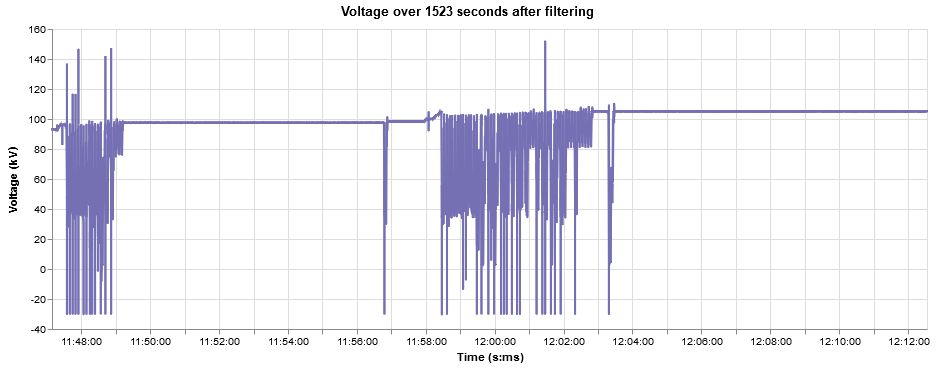

In [9]:
base = generate_line_chart(x_title="Time (s:ms)", y_title="Voltage (kV)",  time_unit="hoursminutesseconds", y_scale=(-40,160))

alt.layer(base, data=flattened_filtered_data, 
          title="Voltage over {} seconds after filtering".format(time_period(flattened_filtered_data)), 
          config={"background": "white"},
          width = 875
         )

We are going to run the same analysis on the unfiltered data for comparison.

In [10]:
flattened_calibrated_data = flatten_data(calibrated_data)
flattened_calibrated_data.head()

,Datetime,Value
0,2018-11-09 11:47:09.498566000,96.0522
1,2018-11-09 11:47:09.510187620,90.3264
2,2018-11-09 11:47:09.521809240,96.0074
3,2018-11-09 11:47:09.533430860,90.3264
4,2018-11-09 11:47:09.545052480,96.0584


In [11]:
flattened_calibrated_data.shape

(129100, 2)

Now we plot the raw signal.

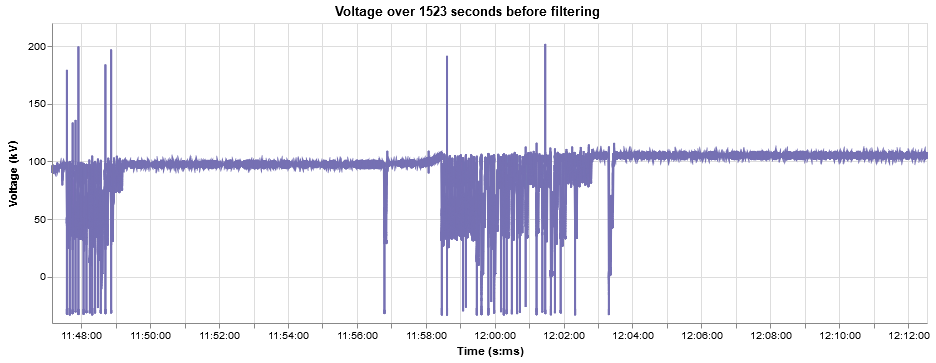

In [12]:
base = generate_line_chart(x_title="Time (s:ms)", y_title="Voltage (kV)",  time_unit="hoursminutesseconds", y_scale=(-40,220))

alt.layer(base, data=flattened_calibrated_data, 
          title="Voltage over {} seconds before filtering".format(time_period(flattened_filtered_data)), 
          config={"background": "white"},
          width = 875
         )

Lets compare the spread of the two different datasets

In [13]:
np.std(flattened_calibrated_data["Value"])

22.092734119000088

In [14]:
np.std(flattened_filtered_data["Value"])

21.913262043137387

We can see 4 areas with sparks occuring in both the original and filtered dataset, however the features become more distinct in the latter. Interestingly, the drops remain around the same values whereas those of the spikes decrease significantly after averaging the values.

## Counting sparks

In [15]:
steady_voltage = 90
spark_voltage = 10
raw_sparks = []
stable = False
first = True

for index, row in flattened_calibrated_data.iterrows():
    value = row['Value']
    time = row['Datetime']
    if first:
        unstable_reading = time
        first = False
    if (value < steady_voltage - spark_voltage):
        unstable_reading = time
        if stable:
            raw_sparks.append(row)
            stable = False
    else:
        if time - unstable_reading >= pd.Timedelta(seconds=2):
            stable = True

len(raw_sparks)

25

In [16]:
steady_voltage = 90
spark_voltage = 10
filtered_sparks = []
stable = False
first = True

for index, row in flattened_filtered_data.iterrows():
    value = row['Value']
    time = row['Datetime']
    if first:
        unstable_reading = time
        first = False
    if (value < steady_voltage - spark_voltage):
        unstable_reading = time
        if stable:
            filtered_sparks.append(row)
            stable = False
    else:
        if time - unstable_reading >= pd.Timedelta(seconds=2):
            stable = True
            
len(filtered_sparks)

18

Implementing the algorithm to include a stable band gives us no sparks. However, this is because of the steady voltage value changes over the dataset as the voltage was increased. In practice, the steady voltage value would have to be set by the user at run time.

In [17]:
steady_voltage = 90
spark_voltage = 10
filtered_sparks_with_band = []
stable = False
first = True

for index, row in flattened_filtered_data.iterrows():
    value = row['Value']
    time = row['Datetime']
    if first:
        unstable_reading = time
        first = False
    if (value < steady_voltage - spark_voltage):
        unstable_reading = time
        if stable:
            filtered_sparks_with_band.append(row)
            stable = False
    elif steady_voltage - 1 < value < steady_voltage + 1:
        if time - unstable_reading >= pd.Timedelta(seconds=2):
            stable = True
    else:
        unstable_reading = time

len(filtered_sparks_with_band)

0

Lets plot vertical rules on the voltage chart to indicate where the sparks are and look at the difference between raw and filtered sparks.

In [18]:
raw_sparks_df = pd.DataFrame(raw_sparks, columns=["Datetime"])
filtered_sparks_df = pd.DataFrame(filtered_sparks, columns=["Datetime"])

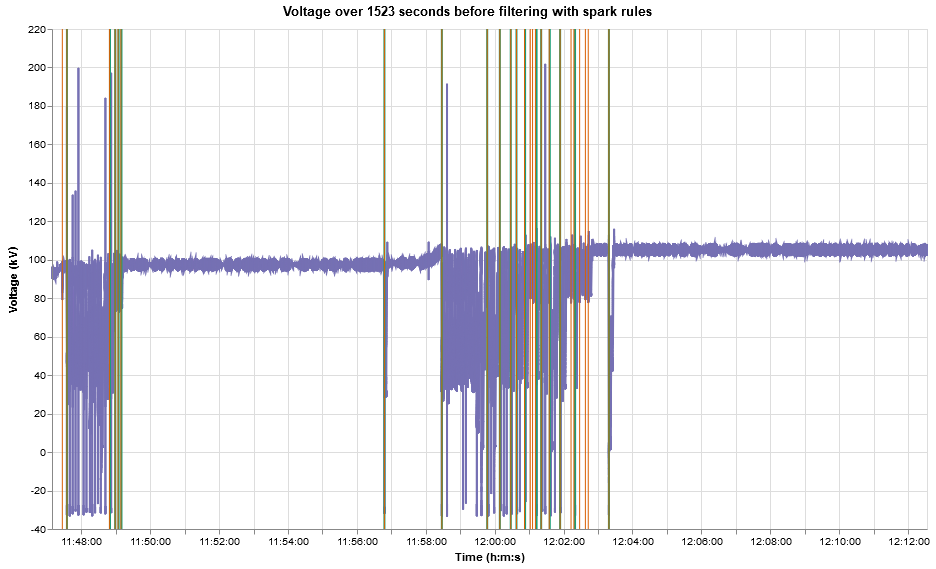

In [19]:
base = generate_line_chart(x_title="Time (h:m:s)", y_title="Voltage (kV)",  time_unit="hoursminutesseconds", y_scale=(-40,220))

red = "#d95f02"
green = "#1b9e77"
filtered_sparks_chart= alt.Chart(filtered_sparks_df).mark_rule(color=green).encode(
    x = alt.X("Datetime:T", 
              timeUnit = "hoursminutesseconds"),
    size = alt.value(2)
)

raw_sparks_chart= alt.Chart(raw_sparks_df).mark_rule(color=red).encode(
    x = alt.X("Datetime:T", timeUnit = "hoursminutesseconds"),
    size = alt.value(1)
)

alt.layer(base, filtered_sparks_chart, raw_sparks_chart, data=flattened_calibrated_data, 
          title="Voltage over {} seconds before filtering with spark rules".format(time_period(flattened_filtered_data)), 
          config={"background": "white"},
          width = 875,
          height = 500
         )

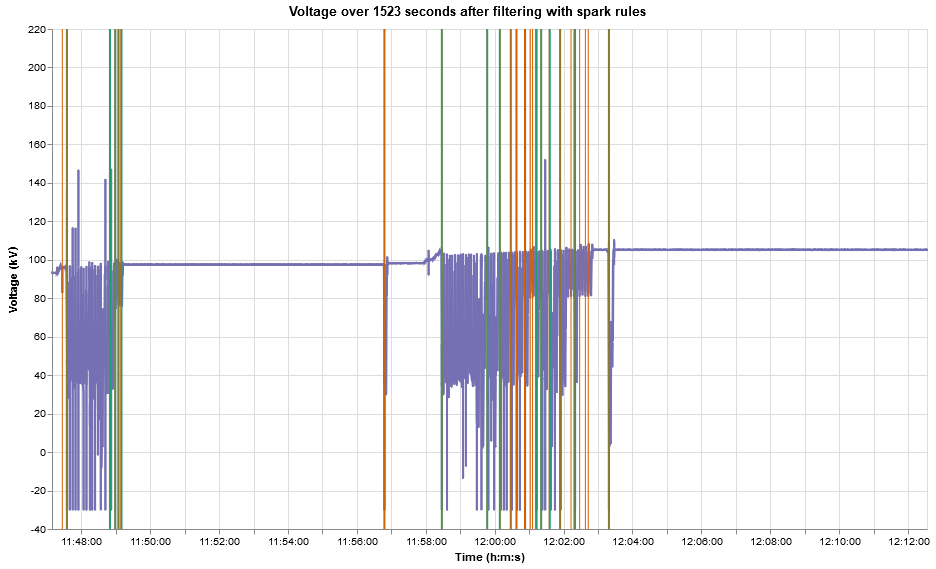

In [20]:
base = generate_line_chart(x_title="Time (h:m:s)", y_title="Voltage (kV)",  time_unit="hoursminutesseconds", y_scale=(-40,220))

red = "#d95f02"
green = "#1b9e77"
filtered_sparks_chart= alt.Chart(filtered_sparks_df).mark_rule(color=green).encode(
    x = alt.X("Datetime:T", timeUnit = "hoursminutesseconds"),
    size = alt.value(2)
)

raw_sparks_chart= alt.Chart(raw_sparks_df).mark_rule(color=red).encode(
    x = alt.X("Datetime:T", timeUnit = "hoursminutesseconds"),
    size = alt.value(1)
)

alt.layer(base, filtered_sparks_chart, raw_sparks_chart, data=flattened_filtered_data, 
          title="Voltage over {} seconds after filtering with spark rules".format(time_period(flattened_filtered_data)), 
          config={"background": "white"},
          width = 875,
          height = 500
         )

Let's look the second unstable region where sparks occur around 12:00.

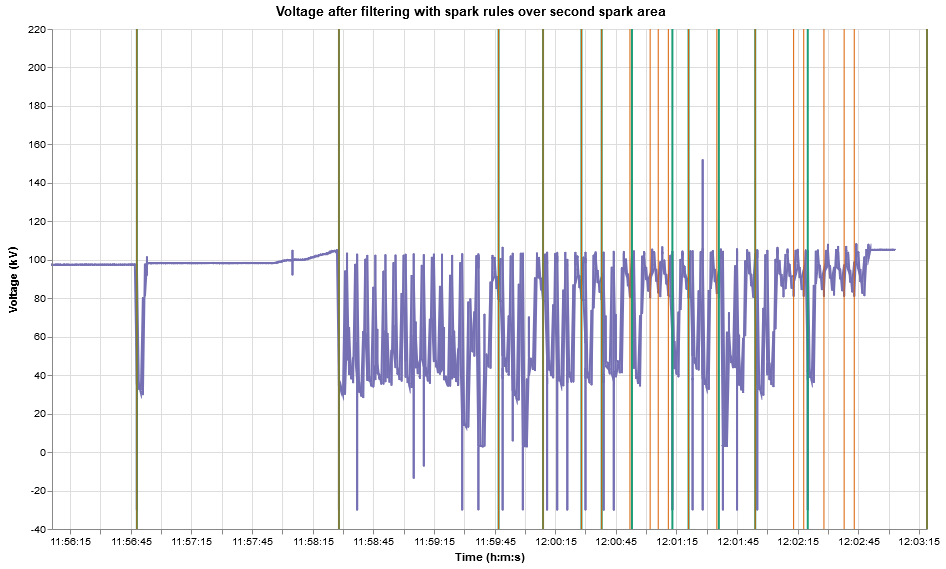

In [21]:
base = generate_line_chart(x_title="Time (h:m:s)", y_title="Voltage (kV)",  time_unit="hoursminutesseconds", y_scale=(-40,220))

red = "#d95f02"
green = "#1b9e77"
filtered_sparks_chart= alt.Chart(filtered_sparks_df[5:]).mark_rule(color=green).encode(
    x = alt.X("Datetime:T", timeUnit = "hoursminutesseconds"),
    size = alt.value(2)
)

raw_sparks_chart= alt.Chart(raw_sparks_df[6:]).mark_rule(color=red).encode(
    x = alt.X("Datetime:T", timeUnit = "hoursminutesseconds"),
    size = alt.value(1)
)

alt.layer(base, filtered_sparks_chart, raw_sparks_chart, data=flattened_filtered_data[45000:80000], 
          title="Voltage after filtering with spark rules over second spark area ".format(time_period(flattened_filtered_data)), 
          config={"background": "white"},
          width = 875,
          height = 500
         )

## Conclusion

In conclusion, it looks like the filtering does affect the number of sparks counted, however, those filtered out don't appear to be real sparks but a product of the noise. The algorithm for determining sparks does look like it needs revisiting because steady voltage needs to change with the signal. Otherwise, it never reaches a stable state.